In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import bbobtorch

c:\Users\Pascal\DataScience\Anaconda\envs\CudaEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# generate ground truth from BBOB function suite
n_dim = 2
problem = bbobtorch.create_f24(n_dim, seed=42)

c:\Users\Pascal\DataScience\Anaconda\envs\CudaEnv\lib\site-packages\bbobtorch\utils.py:44: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2497.)
  R, _ = t.qr(R)


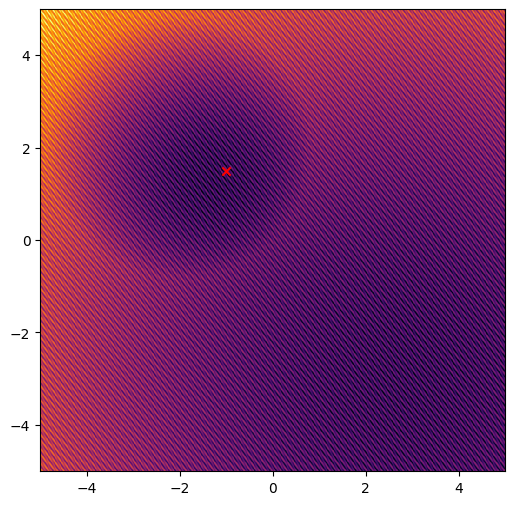

In [24]:
x = torch.arange(-5,5, 0.01, dtype=torch.float32)
grid = torch.stack(torch.meshgrid((x,)*n_dim), -1)
flat_grid = torch.reshape(grid, (-1,n_dim))
xgrid, ygrid = np.meshgrid(x.numpy(), x.numpy())

results = problem(flat_grid)
results_grid = torch.reshape(results, xgrid.shape) - problem.f_opt

plt.figure(figsize=(6,6))
plt.pcolormesh(xgrid, ygrid, results_grid, cmap='inferno', shading='nearest')
plt.scatter(*problem.x_opt.tolist()[::-1], marker='x', c='r')
plt.show()

In [4]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_dim, 10)
        self.fc2 = torch.nn.Linear(10, 10)
        self.fc3 = torch.nn.Linear(10, 10)
        self.fc4 = torch.nn.Linear(10, 10)
        self.fc5 = torch.nn.Linear(10, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x)) 
        x = torch.relu(self.fc3(x)) 
        x = torch.relu(self.fc4(x)) 
        x = self.fc5(x)
        return x
    
model = NN() # du NoName

In [28]:
# train
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

for i in range(10000):
    optimizer.zero_grad()
    #sample flat grid
    flat_grid = torch.rand((1000, n_dim)) * 10 - 5
    results = problem(flat_grid)

    preds = model(flat_grid).flatten()
    loss = loss_fn(preds, results)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(loss.item())


144.35324096679688
130.67074584960938
134.0194854736328
129.4951629638672
119.60163879394531
117.83148193359375
122.02206420898438
121.36328125
117.5460205078125
110.029541015625
110.7603988647461
108.2424545288086
109.53495788574219
107.70648193359375
114.6113510131836
113.24403381347656
109.49068450927734
104.95759582519531
105.40400695800781
109.99703216552734
109.50433349609375
105.5927963256836
106.90650939941406
104.72948455810547
109.86392974853516
102.7305679321289
103.60502624511719
103.03543090820312
105.20333862304688
99.39086151123047
109.19107818603516
105.81221008300781
102.97437286376953
98.8976821899414
103.67828369140625
99.6309585571289
106.96774291992188
107.53067016601562
102.22309875488281
100.43617248535156
105.64324188232422
107.54415893554688
101.58329010009766
104.86760711669922
104.85990905761719
103.7757568359375
105.32389068603516
102.02379608154297
105.9894790649414
111.11134338378906
101.35198211669922
106.12598419189453
109.67727661132812
110.983177185058

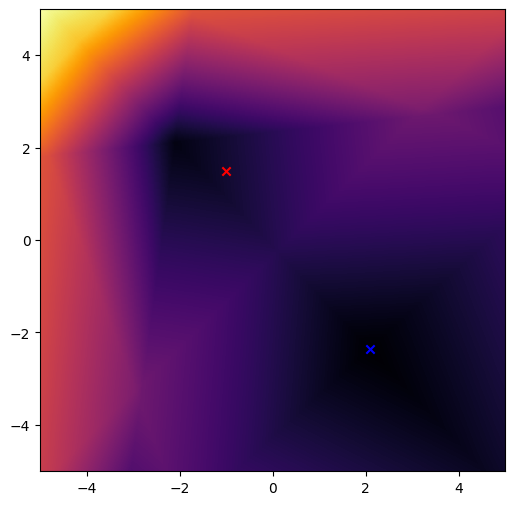

In [29]:
# plot from sampled grid
sample_grid = torch.stack(torch.meshgrid(x, x), -1)
sample_flat_grid = torch.reshape(sample_grid, (-1,2))
sample_results = model(sample_flat_grid)
sample_results_grid = torch.reshape(sample_results, xgrid.shape) - problem.f_opt

plt.figure(figsize=(6,6))
plt.pcolormesh(xgrid, ygrid, sample_results_grid.detach().numpy(), cmap='inferno', shading='nearest')
plt.scatter(*problem.x_opt.tolist()[::-1], marker='x', c='r')
# scatter optimum of sampled grid
sample_opt = sample_flat_grid[torch.argmin(sample_results)]
plt.scatter(*sample_opt.tolist()[::-1], marker='x', c='b')
plt.show()


In [30]:
# und jetzt n optimierer drauf ballern hehehe!
import scipy.optimize as opt
def f(x):
    return model(torch.tensor(x, dtype=torch.float32)).item()

x0 = np.array([0,0])
res = opt.minimize(f, x0, method='nelder-mead',
                options={'xatol': 1e-8, 'disp': True})
print(res.x)


Optimization terminated successfully.
         Current function value: -351.864136
         Iterations: 105
         Function evaluations: 225
[ 2.10329527 -2.10479034]


In [35]:
# same as above but with sdtw
# use soft dtw
model = NN()
from soft_dtw import SoftDTW
loss_fn = SoftDTW(use_cuda=True, gamma=1.0, normalize=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(10000):
    optimizer.zero_grad()
    #sample flat grid, with dim bs, len, n_dim
    flat_grid = torch.rand((1000, n_dim)) * 10 - 5
    results = problem(flat_grid)

    preds = model(flat_grid).flatten()

    # sort preds and results for soft dtw in order of flat_grid
    preds = preds[torch.argsort(flat_grid[:,0])]
    results = results[torch.argsort(flat_grid[:,0])]

    # reshape 
    preds = preds[None, None, :]
    results = results[None, None, :]

    #to cuda
    preds = preds.to("cuda")
    results = results.to("cuda")


    loss = loss_fn(preds, results)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(loss.item())

110870680.0
111454208.0
87559608.0
13056286.0
9166208.0
8168719.5
6201233.5
5197117.0
4006464.0
2699368.25
1408073.875
615183.375
295427.5625
204492.875
160491.421875
167428.703125
145994.59375
145414.078125
155885.28125
140962.875
151228.625
141506.21875
129606.7578125
138728.84375
151774.4375
141397.328125
139446.15625
142228.1875
141823.921875
134048.953125
131049.859375
147056.0
135641.6875
129748.828125
136977.0
131944.5
141078.890625
129170.96875
134144.890625
141408.578125
132237.875
136145.875
139919.328125
130083.4609375
130777.625
131919.25
136195.5625
126422.0
128321.0625
144022.3125
131144.890625
127779.2265625
129787.984375
135108.078125
127817.2890625
133888.140625
127085.8984375
127604.25
140556.453125
118120.6171875
115875.765625
128222.6015625
124565.328125
132062.3125
120893.796875
122691.375
119490.046875
118357.78125
123165.8828125
119882.453125
119930.546875
119364.8046875
119505.4375
111032.28125
113376.28125
115831.078125
113630.2421875
110992.921875
113904.45312

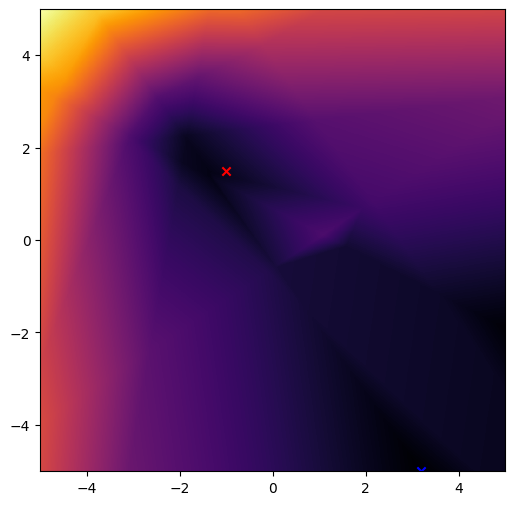

In [36]:
# plot from sampled grid
sample_grid = torch.stack(torch.meshgrid(x, x), -1)
sample_flat_grid = torch.reshape(sample_grid, (-1,2))
sample_results = model(sample_flat_grid)
sample_results_grid = torch.reshape(sample_results, xgrid.shape) - problem.f_opt

plt.figure(figsize=(6,6))
plt.pcolormesh(xgrid, ygrid, sample_results_grid.detach().numpy(), cmap='inferno', shading='nearest')
plt.scatter(*problem.x_opt.tolist()[::-1], marker='x', c='r')
# scatter optimum of sampled grid
sample_opt = sample_flat_grid[torch.argmin(sample_results)]
plt.scatter(*sample_opt.tolist()[::-1], marker='x', c='b')
plt.show()
